<h1>This notebook tracks the spread of the novel coronavirus, also known as SARS-CoV-2. It is a contagious respiratory virus that first started in Wuhan in December 2019. On 2/11/2020, the disease is officially named COVID-19 by the World Health Organization. 
    <br>Data: <a href='https://github.com/CSSEGISandData/COVID-19'>https://github.com/CSSEGISandData/COVID-19</a>. A big thank you to Johns Hopkins for providing the data.
    <br>
    <br>Learn more from the <a href='https://www.who.int/emergencies/diseases/novel-coronavirus-2019'>WHO</a>
    <br>Learn more from the <a href='https://www.cdc.gov/coronavirus/2019-ncov'>CDC</a>
    <br>Map Visualizations from  <a href='https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6'>Johns Hopkins</a>
    <br>Feel free to provide me with feedbacks. 
    <br> Last update: 3/9/2020 9:25 PM
    <br> Make sure you run the notebook to see the graphs better. Some diagrams are hard to see in the default view. 
    <br> <a href='https://github.com/therealcyberlord'>Source code is on my Github</a>
    
</h1>

<center><img src='https://newsfortomorrow.com/wp-content/uploads/2020/01/1578562454_Wuhan-pneumonia-New-coronavirus-related-to-SARS-idenitified.jpg'>
* Source: https://newsfortomorrow.com/wp-content/uploads/2020/01/1578562454_Wuhan-pneumonia-New-coronavirus-related-to-SARS-idenitified.jpg </center>

<h1>Keep strong, world!</h1>






In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
%matplotlib inline 

Import the data (make sure you update this on a daily basis)

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')

In [3]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,...,990,990,990,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,...,411,413,414,414,418,418,422,426,428,428
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,...,576,576,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,...,296,296,296,296,296,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,...,91,91,91,91,91,102,119,120,124,124


In [4]:
cols = confirmed_df.keys()

Get all the dates for the outbreak

In [5]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [6]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
total_recovered = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)
    total_recovered.append(recovered_sum)

In [7]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

Future forcasting

In [8]:
days_in_future = 5
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)

Convert integer into datetime for better visualization

In [9]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))
adjusted_dates = future_forcast_dates[:-5]

In [10]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.1, shuffle=False) 

Model for predicting # of confirmed cases. I am using support vector machine, bayesian ridge , and linear regression in this example. 

In [11]:
kernel = ['linear', 'poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon = [0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel': kernel, 'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking}

svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
svm_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   50.9s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=40, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 1, 10],
                                        'epsilon': [0.01, 0.1, 1],
                                        'gamma': [0.01, 0.1, 1],
                                        'kernel': ['linear', 'poly', 'sigmoid',
                                                   'rbf'],
                                        'shrinking': [True, False]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [12]:
svm_search.best_params_

{'shrinking': True, 'kernel': 'linear', 'gamma': 0.01, 'epsilon': 1, 'C': 10}

In [13]:
svm_confirmed = svm_search.best_estimator_
svm_pred = svm_confirmed.predict(future_forcast)

MAE: 3562.9894736842107
MSE: 18030445.34736842


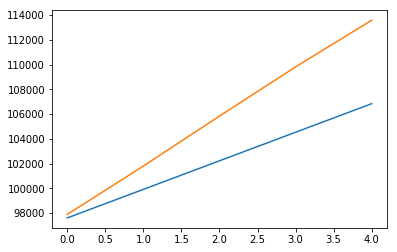

In [14]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(svm_test_pred)
plt.plot(y_test_confirmed)
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [15]:
linear_model = LinearRegression(normalize=True)
linear_model.fit(X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(X_test_confirmed)
linear_pred = linear_model.predict(future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 4757.448746602235
MSE: 26271282.287748296


In [16]:
linear_model.coef_

array([[2593.13168227]])

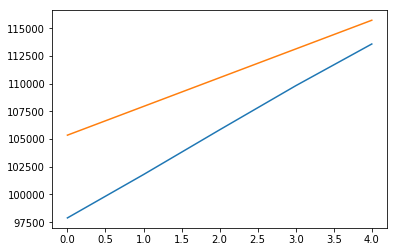

In [17]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)

In [18]:
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge()
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           compute_score=False, copy_X=True,
                                           fit_intercept=True, lambda_1=1e-06,
                                           lambda_2=1e-06, n_iter=300,
                                           normalize=False, tol=0.001,
                                           verbose=False),
                   iid='warn', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001],
                                        'lambda_2': [1e

In [19]:
bayesian_search.best_params_

{'tol': 0.01,
 'lambda_2': 0.0001,
 'lambda_1': 1e-07,
 'alpha_2': 1e-05,
 'alpha_1': 0.0001}

In [20]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 4699.355721633998
MSE: 25734970.88723235


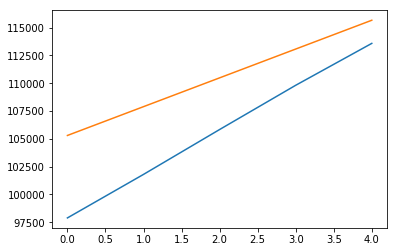

In [21]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)

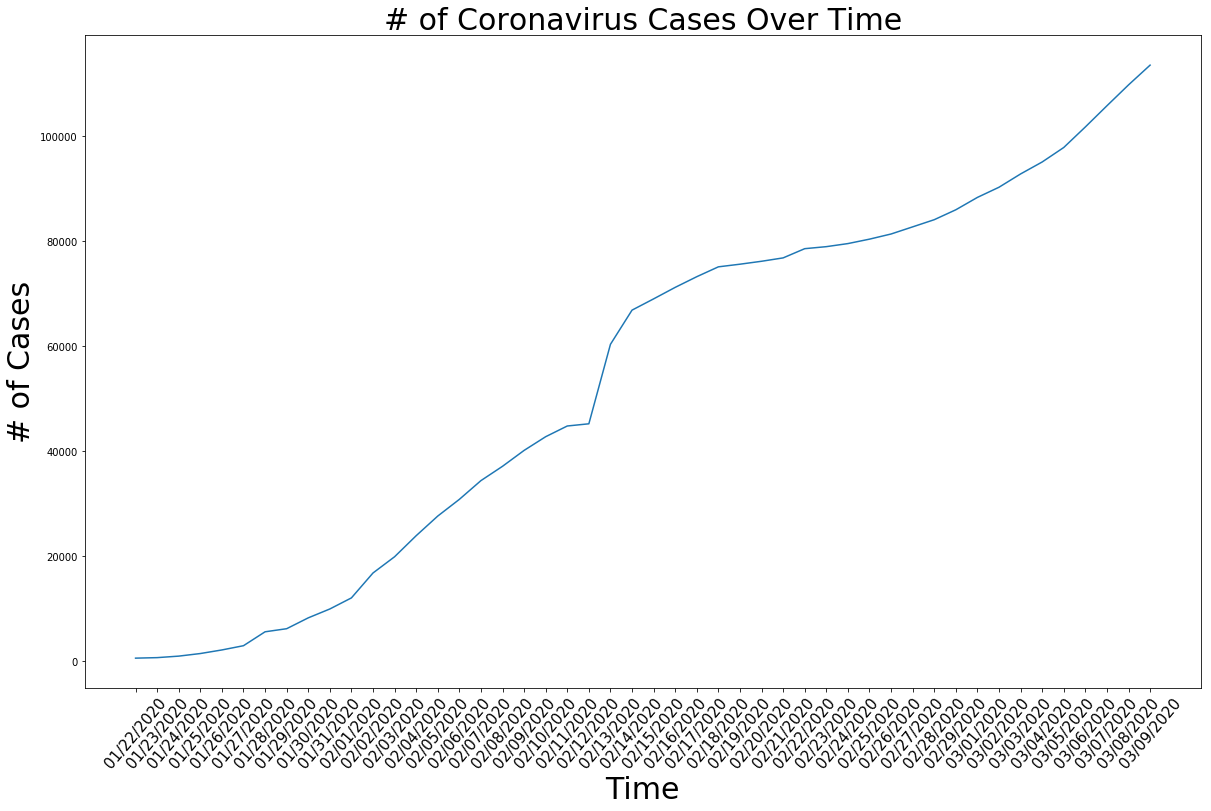

In [22]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(rotation=50, size=15)
plt.show()

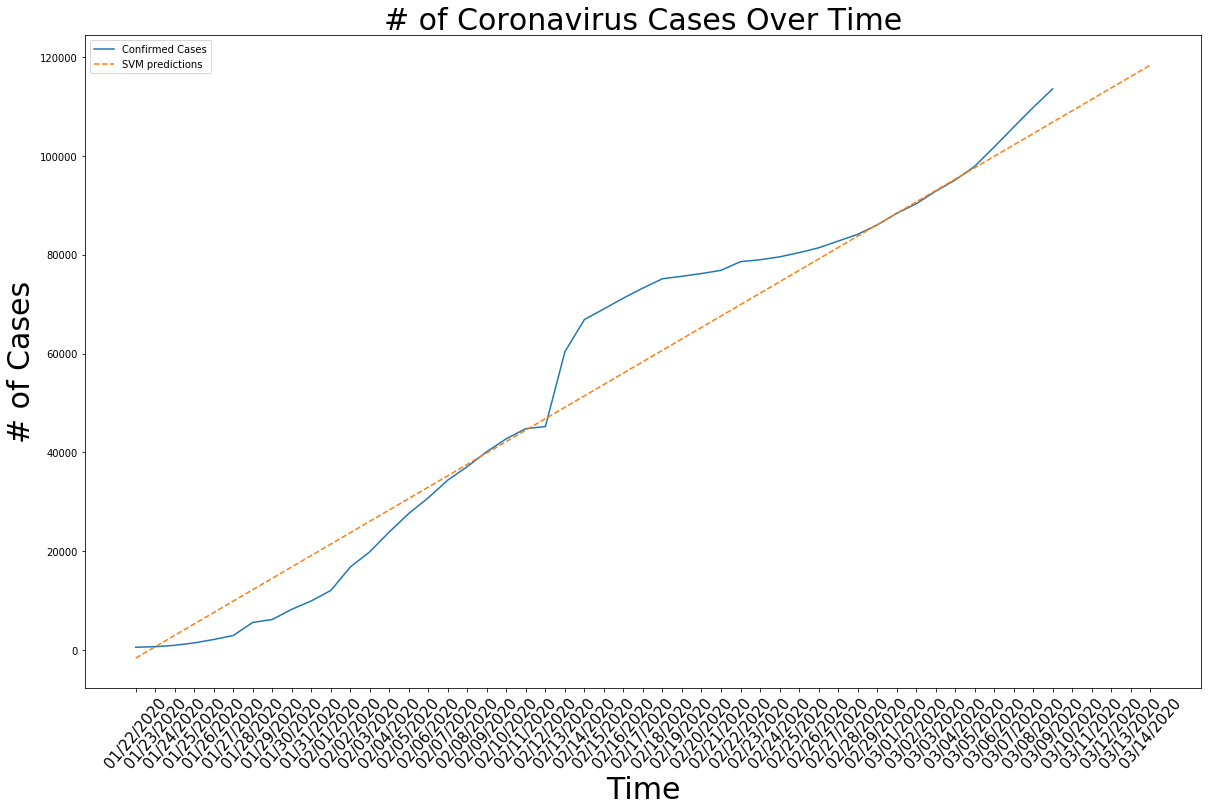

In [23]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast_dates, svm_pred, linestyle='dashed')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions'])
plt.xticks(rotation=50, size=15)
plt.show()

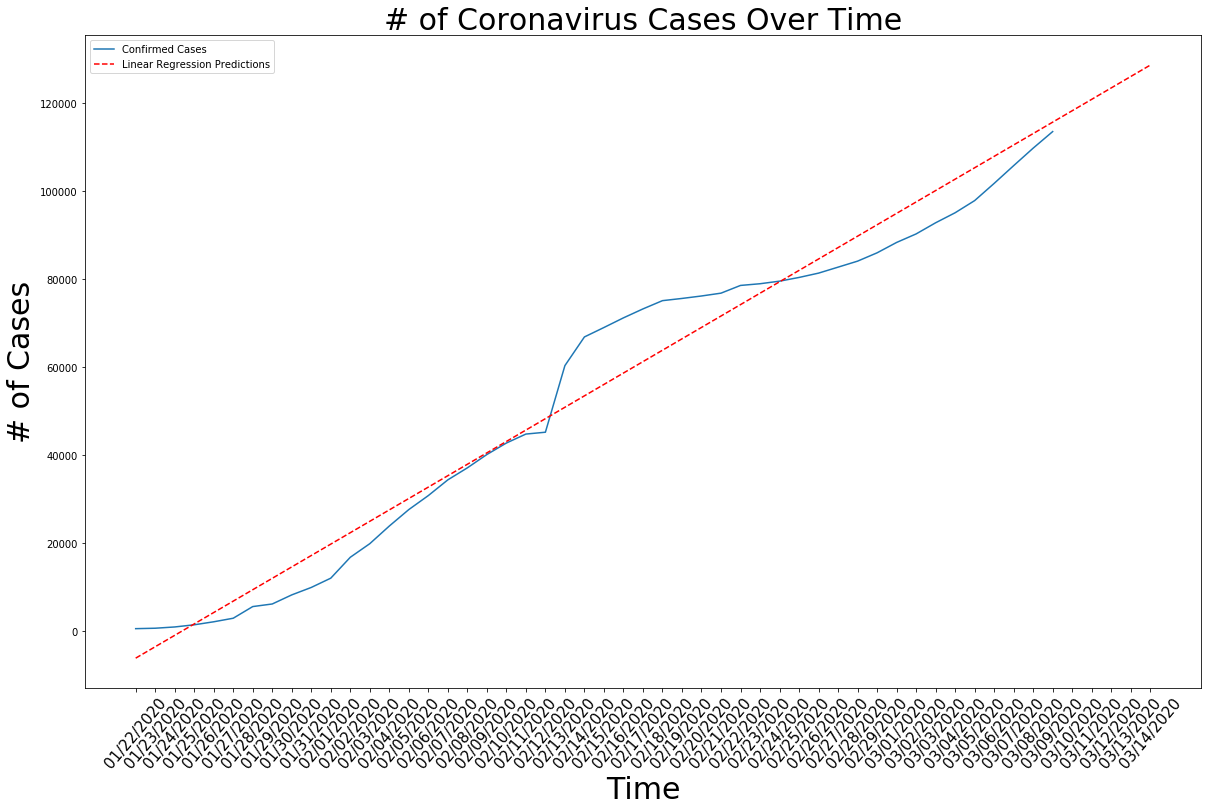

In [24]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast_dates, linear_pred, linestyle='dashed', color='red')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Linear Regression Predictions'])
plt.xticks(rotation=50, size=15)
plt.show()

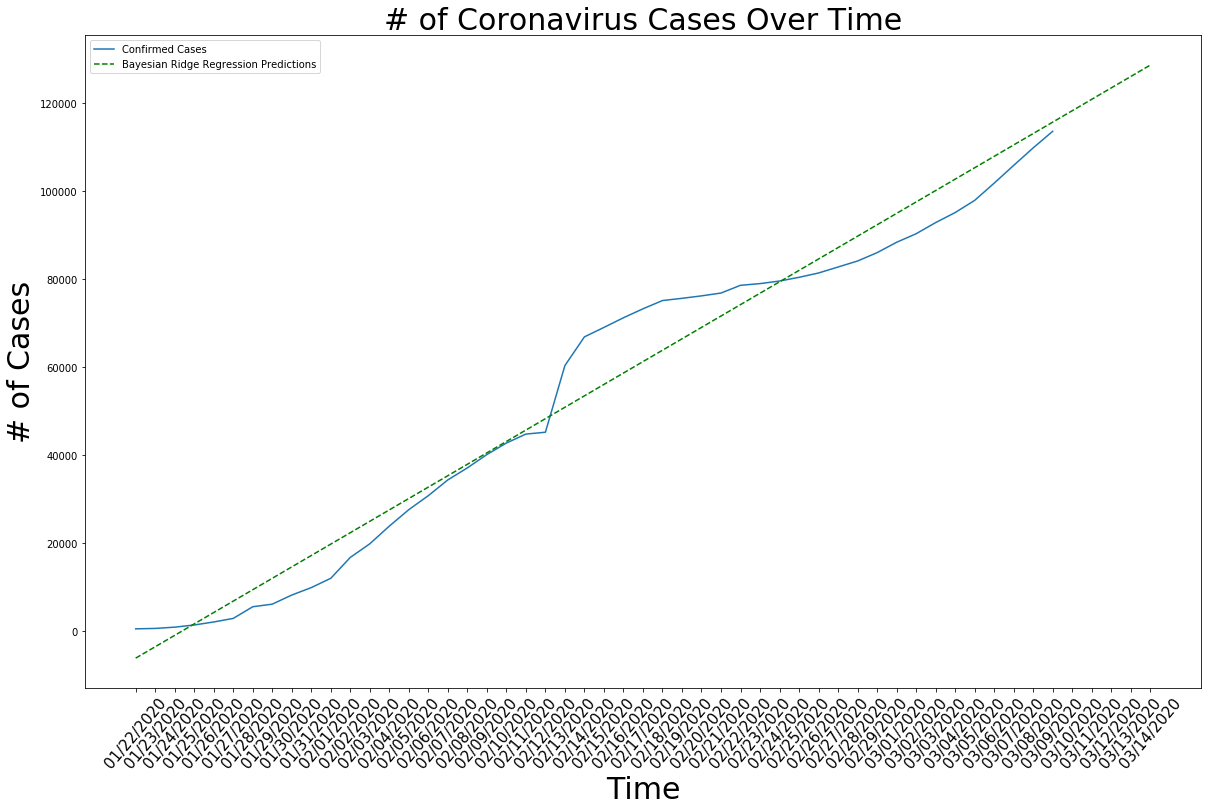

In [25]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast_dates, bayesian_pred, linestyle='dashed', color='green')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Bayesian Ridge Regression Predictions'])
plt.xticks(rotation=50, size=15)
plt.show()

In [26]:
# Future predictions using SVM 
print('SVM future predictions:')
set(zip(future_forcast_dates[-5:], svm_pred[-5:]))

SVM future predictions:


{('03/10/2020', 109145.3157894737),
 ('03/11/2020', 111453.6842105263),
 ('03/12/2020', 113762.05263157895),
 ('03/13/2020', 116070.42105263159),
 ('03/14/2020', 118378.78947368423)}

In [27]:
# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
set(zip(future_forcast_dates[-5:], bayesian_pred[-5:]))

Ridge regression future predictions:


{('03/10/2020', 118254.6891403266),
 ('03/11/2020', 120845.40027989083),
 ('03/12/2020', 123436.11141945503),
 ('03/13/2020', 126026.82255901923),
 ('03/14/2020', 128617.53369858343)}

In [28]:
# Future predictions using Linear Regression 
print('Linear regression future predictions:')
print(linear_pred[-5:])

Linear regression future predictions:
[[118320.04379342]
 [120913.17547569]
 [123506.30715796]
 [126099.43884023]
 [128692.5705225 ]]


 Graphing the number of confirmed cases, deaths, and the mortality rate over time, as well as the number of recoveries

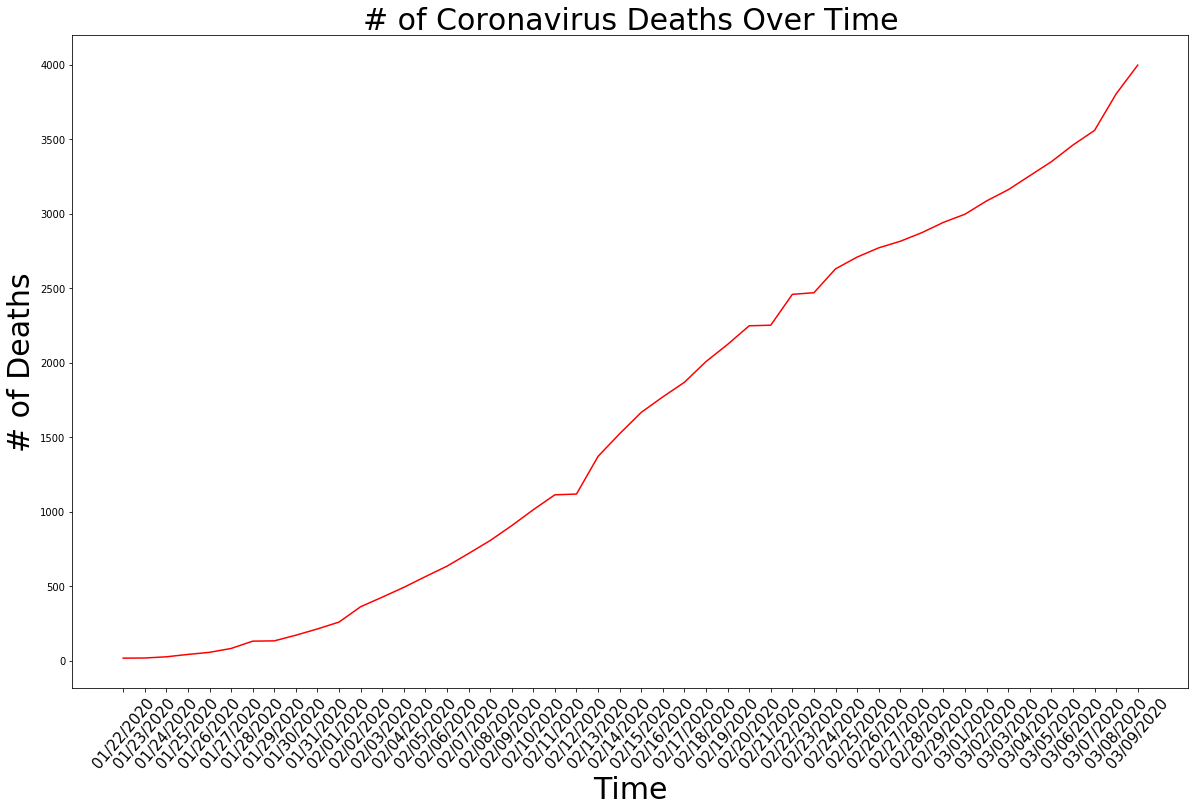

In [29]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Deaths', size=30)
plt.xticks(rotation=50, size=15)
plt.show()

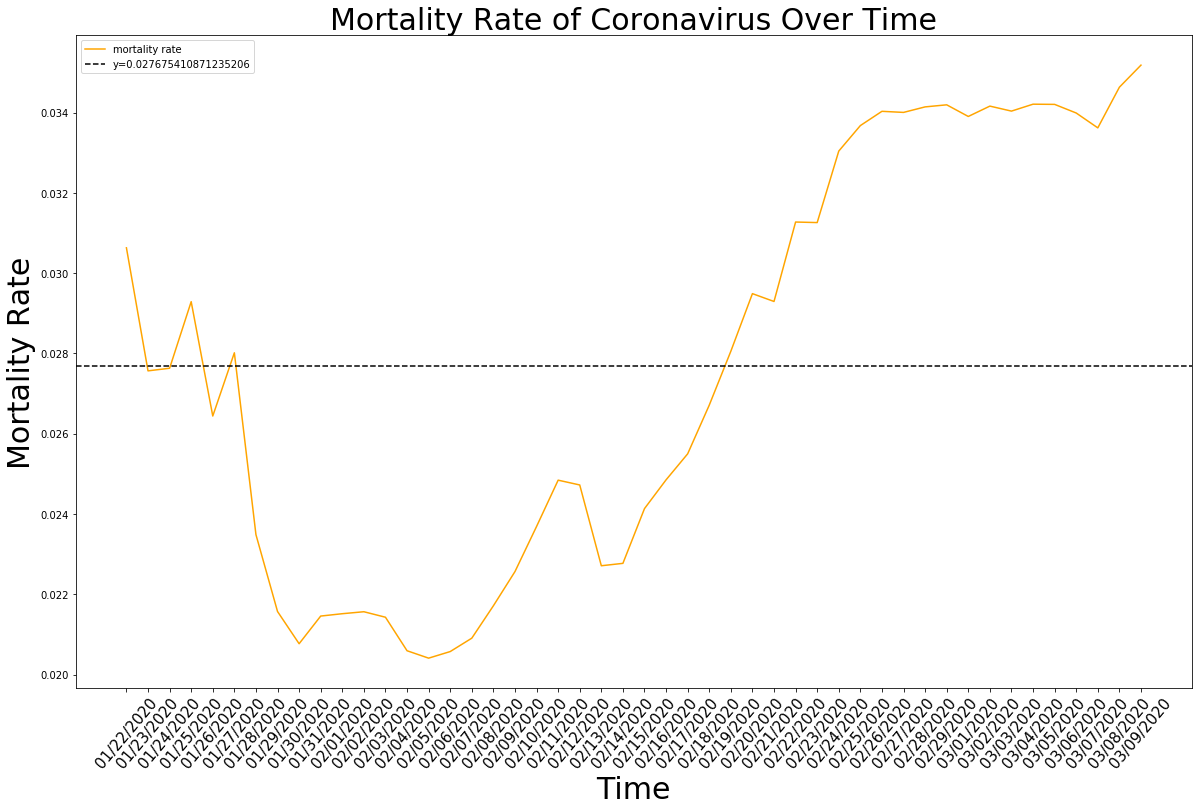

In [30]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)])
plt.xlabel('Time', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(rotation=50, size=15)
plt.show()

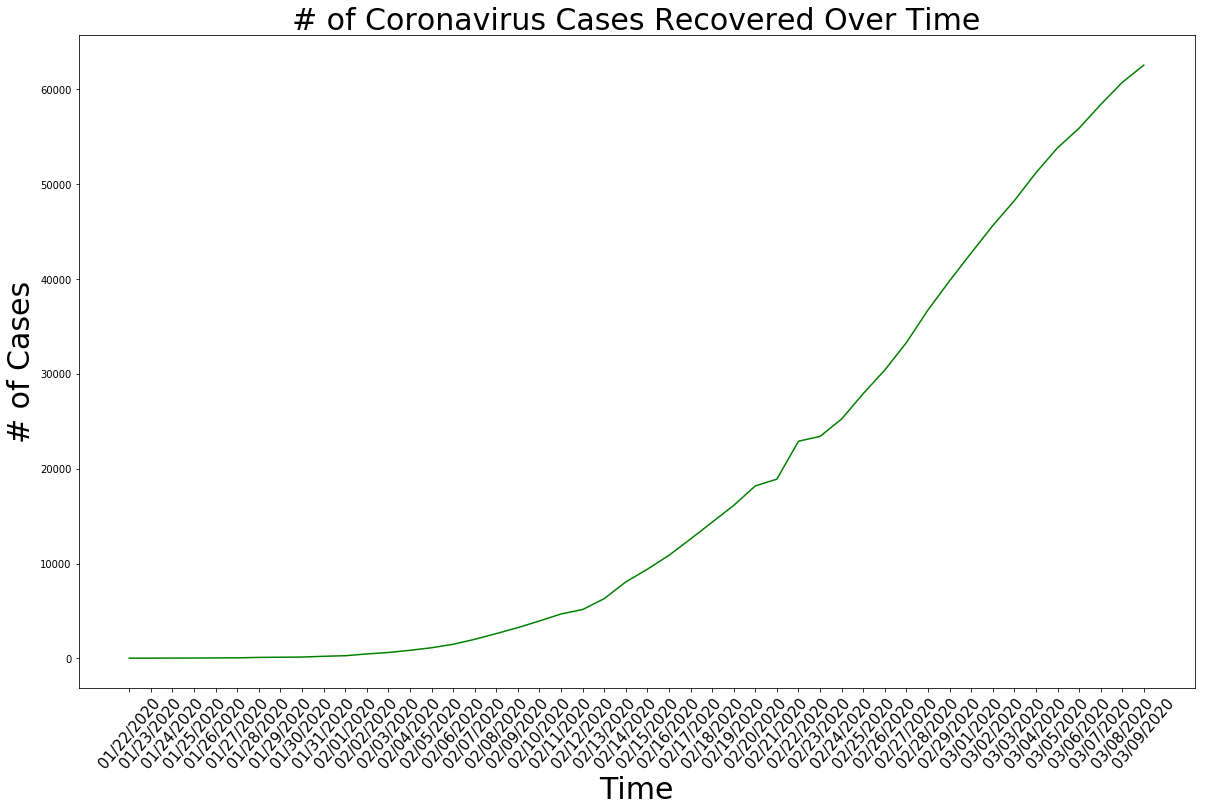

In [31]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_recovered, color='green')
plt.title('# of Coronavirus Cases Recovered Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(rotation=50, size=15)
plt.show()

Graphing the number of deaths and the number of recoveries

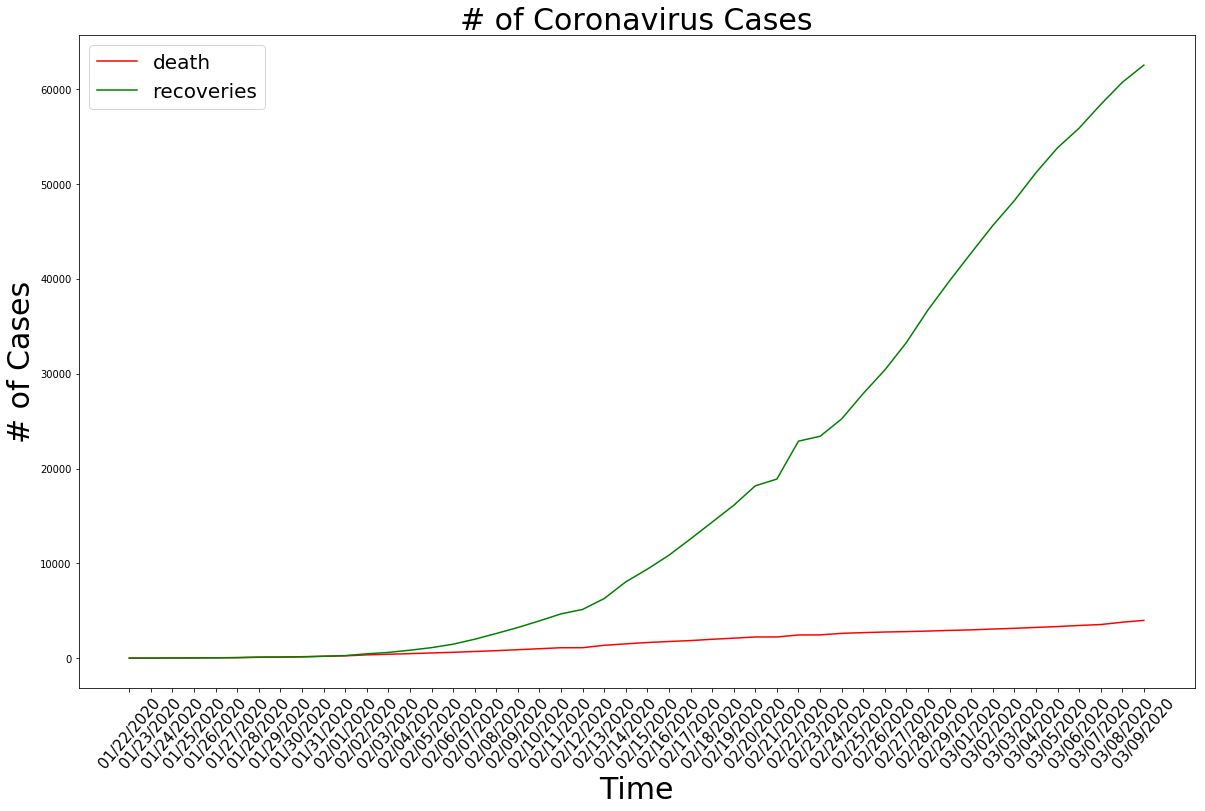

In [32]:
plt.figure(figsize=(20, 12))
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.legend(['death', 'recoveries'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(rotation=50, size=15)
plt.show()

Plotting the number of deaths against the number of recoveries

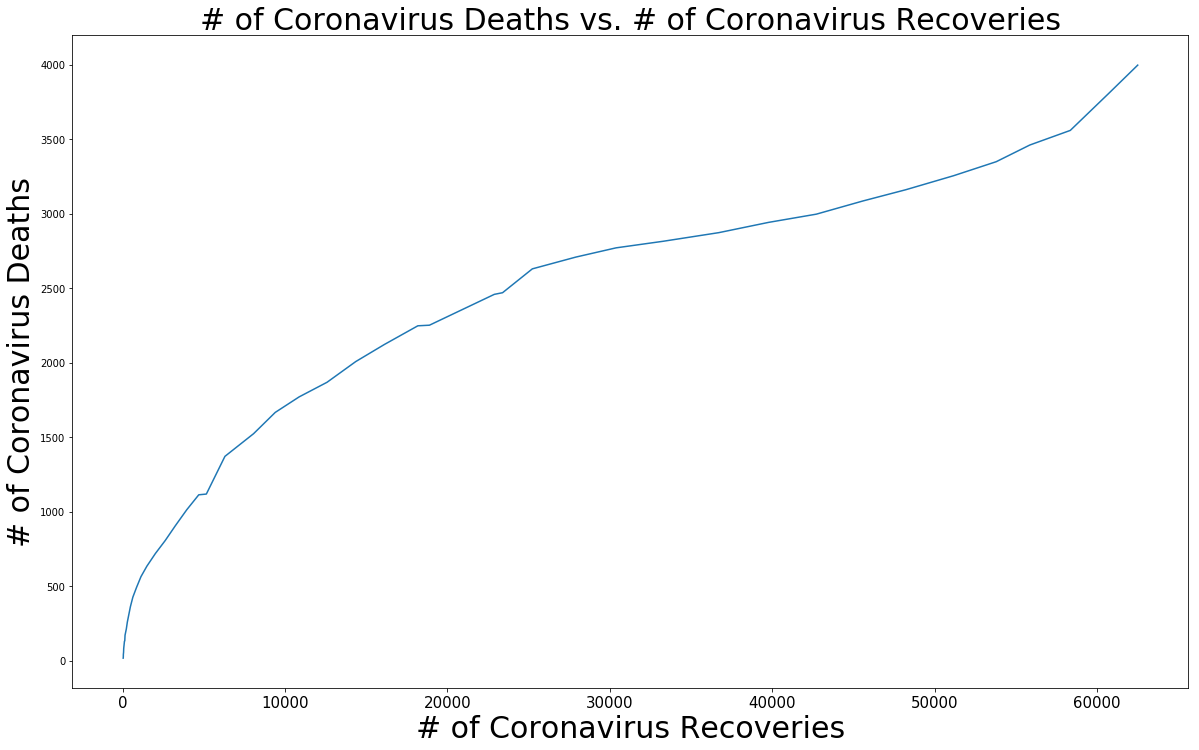

In [33]:
plt.figure(figsize=(20, 12))
plt.plot(total_recovered, total_deaths)
plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
plt.xlabel('# of Coronavirus Recoveries', size=30)
plt.ylabel('# of Coronavirus Deaths', size=30)
plt.xticks(size=15)
plt.show()

Getting the latest information about provinces/states that have confirmed coronavirus cases

In [34]:
latest_confirmed = confirmed_df[dates[-1]]
latest_deaths = deaths_df[dates[-1]]
latest_recoveries = recoveries_df[dates[-1]]

Getting information about countries/regions that have confirmed coronavirus cases

In [35]:
unique_countries =  list(confirmed_df['Country/Region'].unique())

In [36]:
country_confirmed_cases = []
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[confirmed_df['Country/Region']==i].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)

In [37]:
# number of cases per country/region
for i in range(len(unique_countries)):
    print(f'{unique_countries[i]}: {country_confirmed_cases[i]} cases')

Mainland China: 80735 cases
Thailand: 50 cases
Japan: 511 cases
South Korea: 7478 cases
Taiwan: 45 cases
US: 605 cases
Macau: 10 cases
Hong Kong: 115 cases
Singapore: 150 cases
Vietnam: 30 cases
France: 1209 cases
Nepal: 1 cases
Malaysia: 117 cases
Canada: 77 cases
Australia: 91 cases
Cambodia: 2 cases
Sri Lanka: 1 cases
Germany: 1176 cases
Finland: 30 cases
United Arab Emirates: 45 cases
Philippines: 20 cases
India: 43 cases
Italy: 9172 cases
UK: 321 cases
Russia: 17 cases
Sweden: 248 cases
Spain: 1073 cases
Belgium: 239 cases
Others: 696 cases
Egypt: 55 cases
Iran: 7161 cases
Lebanon: 32 cases
Iraq: 60 cases
Oman: 16 cases
Afghanistan: 4 cases
Bahrain: 95 cases
Kuwait: 64 cases
Algeria: 20 cases
Croatia: 12 cases
Switzerland: 374 cases
Austria: 131 cases
Israel: 39 cases
Pakistan: 6 cases
Brazil: 25 cases
Georgia: 15 cases
Greece: 73 cases
North Macedonia: 3 cases
Norway: 205 cases
Romania: 15 cases
Denmark: 90 cases
Estonia: 10 cases
Netherlands: 321 cases
San Marino: 36 cases
Belar

In [38]:
unique_provinces =  list(confirmed_df['Province/State'].unique())

In [39]:
province_confirmed_cases = []
no_cases = [] 
for i in unique_provinces:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)

In [40]:
# number of cases per province/state/city

for i in range(len(unique_provinces)):
    print(f'{unique_provinces[i]}: {province_confirmed_cases[i]} cases')

Anhui: 990 cases
Beijing: 428 cases
Chongqing: 576 cases
Fujian: 296 cases
Gansu: 124 cases
Guangdong: 1352 cases
Guangxi: 252 cases
Guizhou: 146 cases
Hainan: 168 cases
Hebei: 318 cases
Heilongjiang: 481 cases
Henan: 1272 cases
Hubei: 67743 cases
Hunan: 1018 cases
Inner Mongolia: 75 cases
Jiangsu: 631 cases
Jiangxi: 935 cases
Jilin: 93 cases
Liaoning: 125 cases
Ningxia: 75 cases
Qinghai: 18 cases
Shaanxi: 245 cases
Shandong: 758 cases
Shanghai: 342 cases
Shanxi: 133 cases
Sichuan: 539 cases
Tianjin: 136 cases
Tibet: 1 cases
Xinjiang: 76 cases
Yunnan: 174 cases
Zhejiang: 1215 cases
Taiwan: 45 cases
King County, WA: 83 cases
Cook County, IL: 7 cases
Macau: 10 cases
Hong Kong: 115 cases
British Columbia: 32 cases
Los Angeles, CA: 14 cases
New South Wales: 48 cases
Victoria: 15 cases
Queensland: 15 cases
South Australia: 7 cases
San Benito, CA: 2 cases
Madison, WI: 1 cases
Diamond Princess cruise ship: 696 cases
San Diego County, CA: 3 cases
San Antonio, TX: 1 cases
Humboldt County, CA: 1

In [41]:
nan_indices = [] 

# handle nan if there is any, it is usually a float: float('nan')

for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

***Visual Representations*** (bar charts and pie charts)

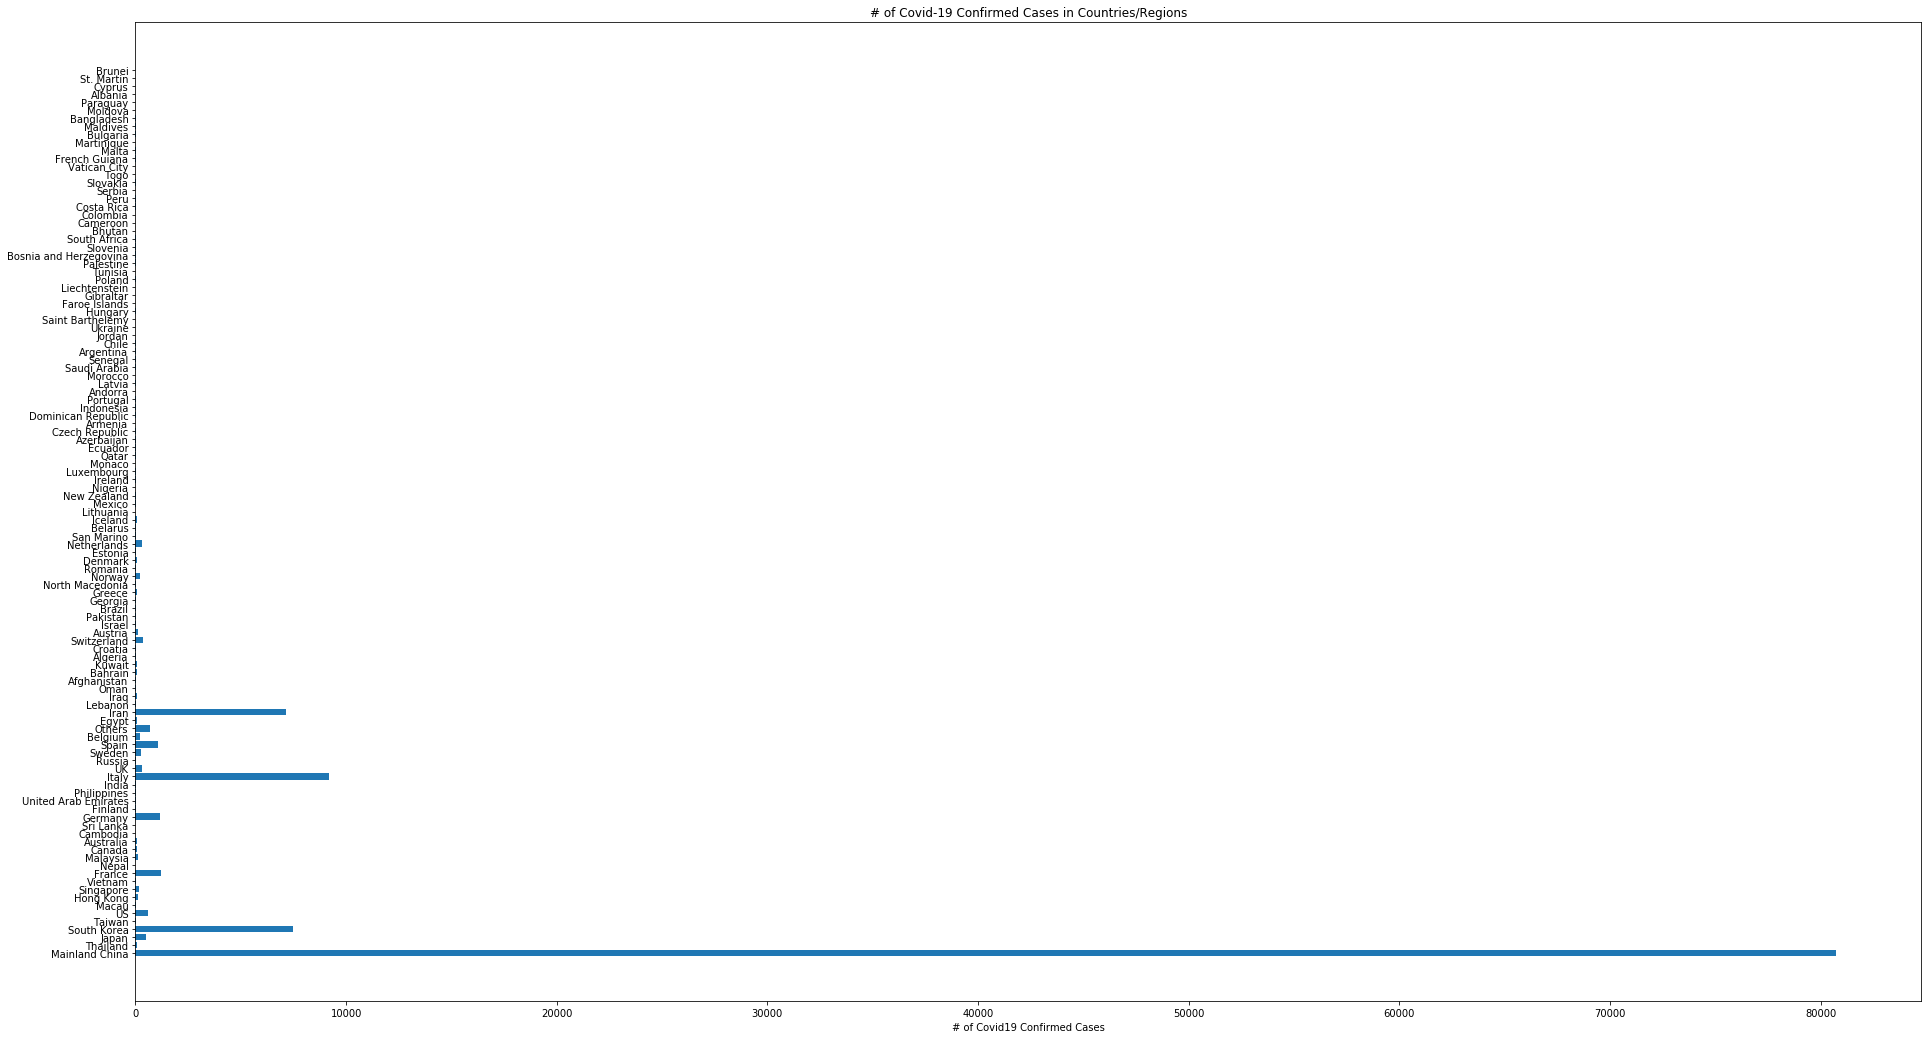

In [42]:
plt.figure(figsize=(32, 18))
plt.barh(unique_countries, country_confirmed_cases)
plt.title('# of Covid-19 Confirmed Cases in Countries/Regions')
plt.xlabel('# of Covid19 Confirmed Cases')
plt.show()

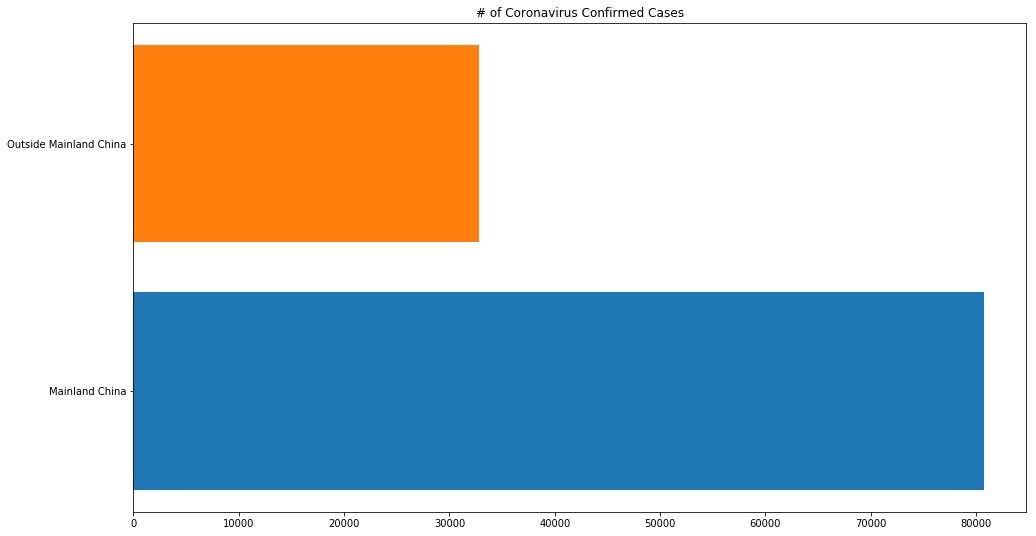

In [43]:
outside_mainland_china_confirmed = np.sum(country_confirmed_cases[1:])
plt.figure(figsize=(16, 9))
plt.barh(unique_countries[0], country_confirmed_cases[0])
plt.barh('Outside Mainland China', outside_mainland_china_confirmed)
plt.title('# of Coronavirus Confirmed Cases')
plt.show()

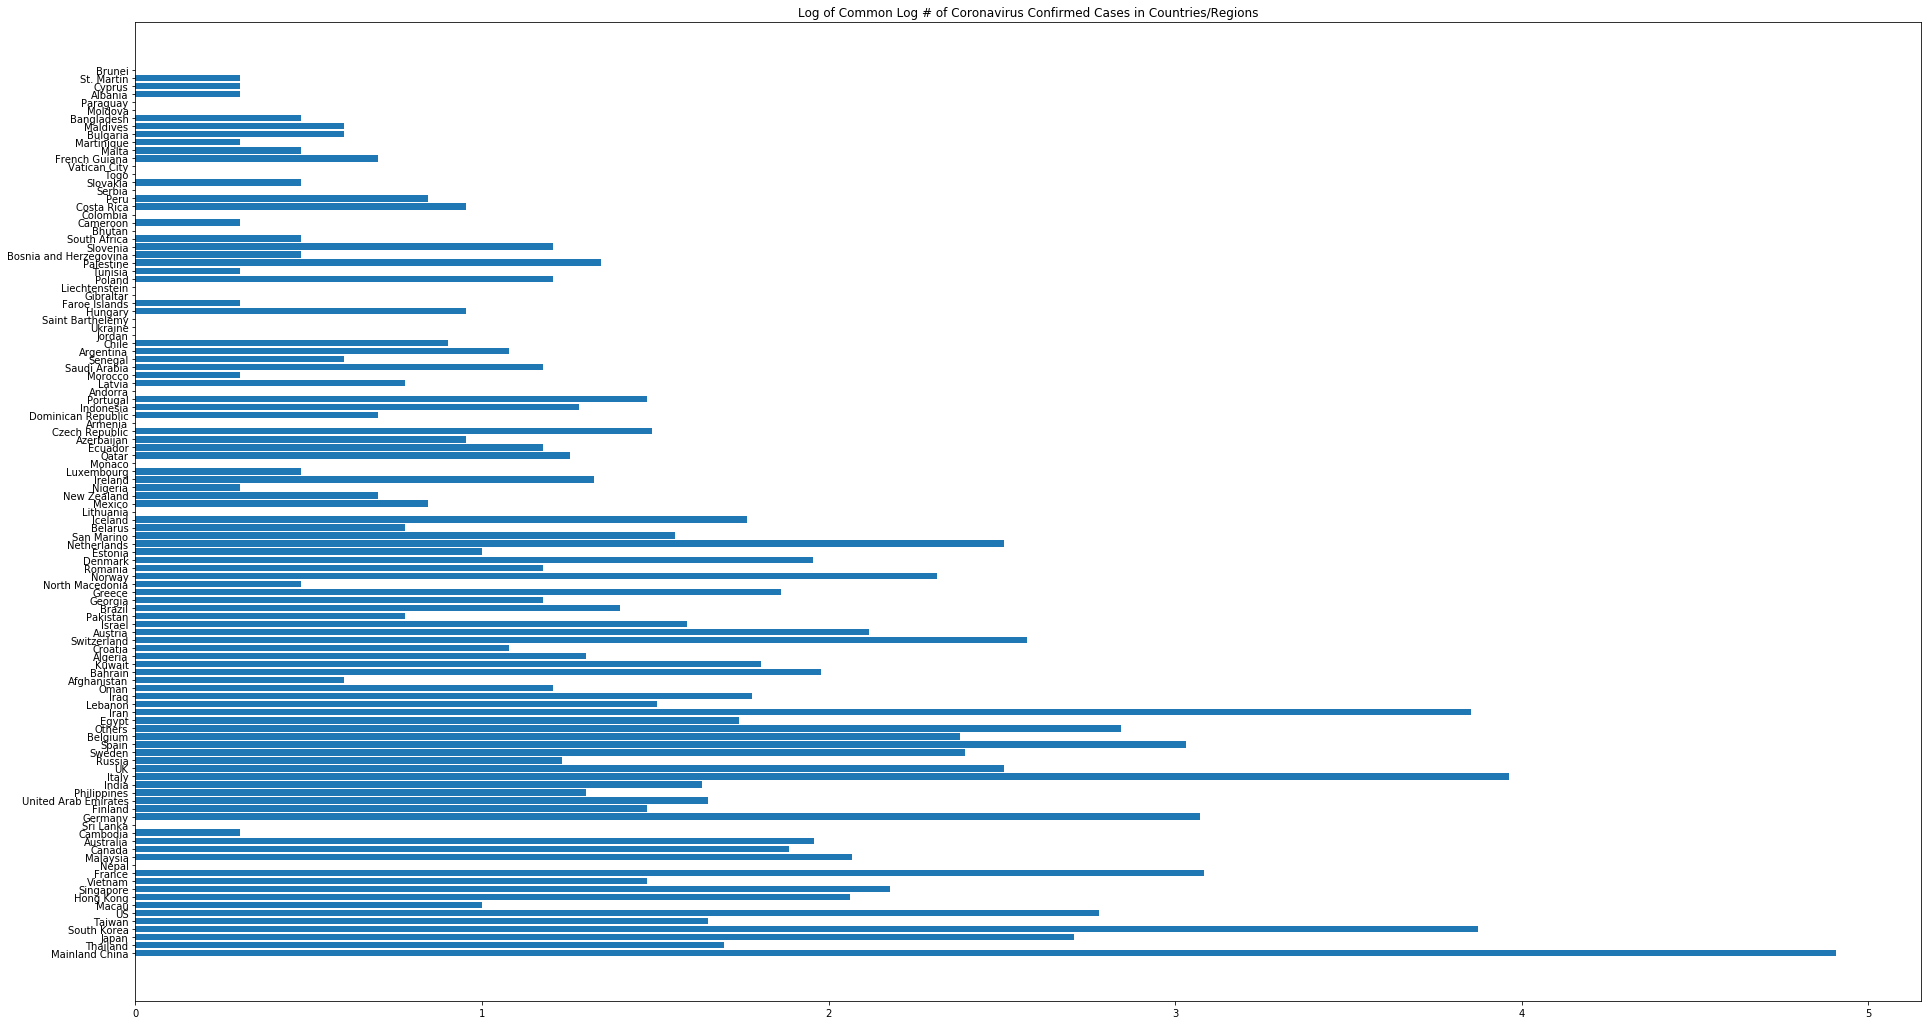

In [44]:
# lets look at it in a logarithmic scale 
log_country_confirmed_cases = [math.log10(i) for i in country_confirmed_cases]
plt.figure(figsize=(32, 18))
plt.barh(unique_countries, log_country_confirmed_cases)
plt.title('Log of Common Log # of Coronavirus Confirmed Cases in Countries/Regions')
plt.show()

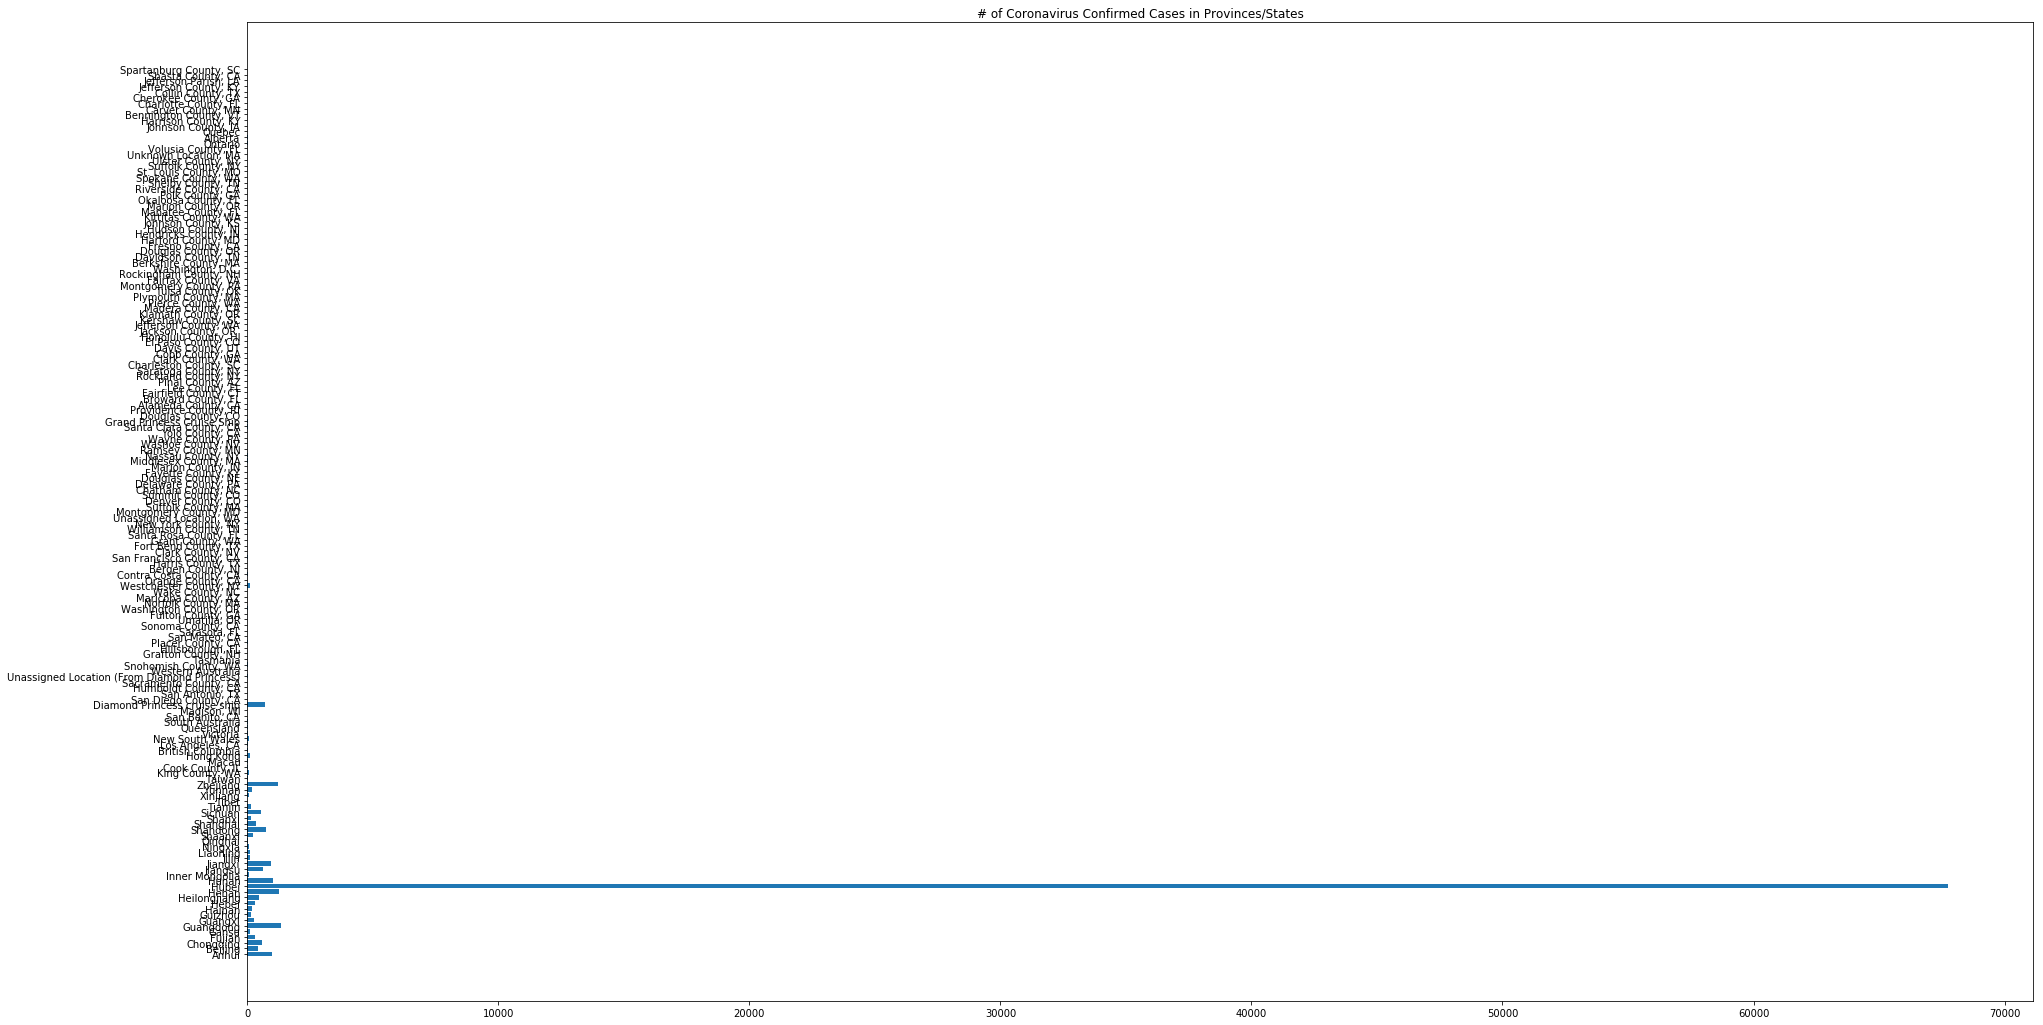

In [45]:
plt.figure(figsize=(32, 18))
plt.barh(unique_provinces, province_confirmed_cases)
plt.title('# of Coronavirus Confirmed Cases in Provinces/States')
plt.show()

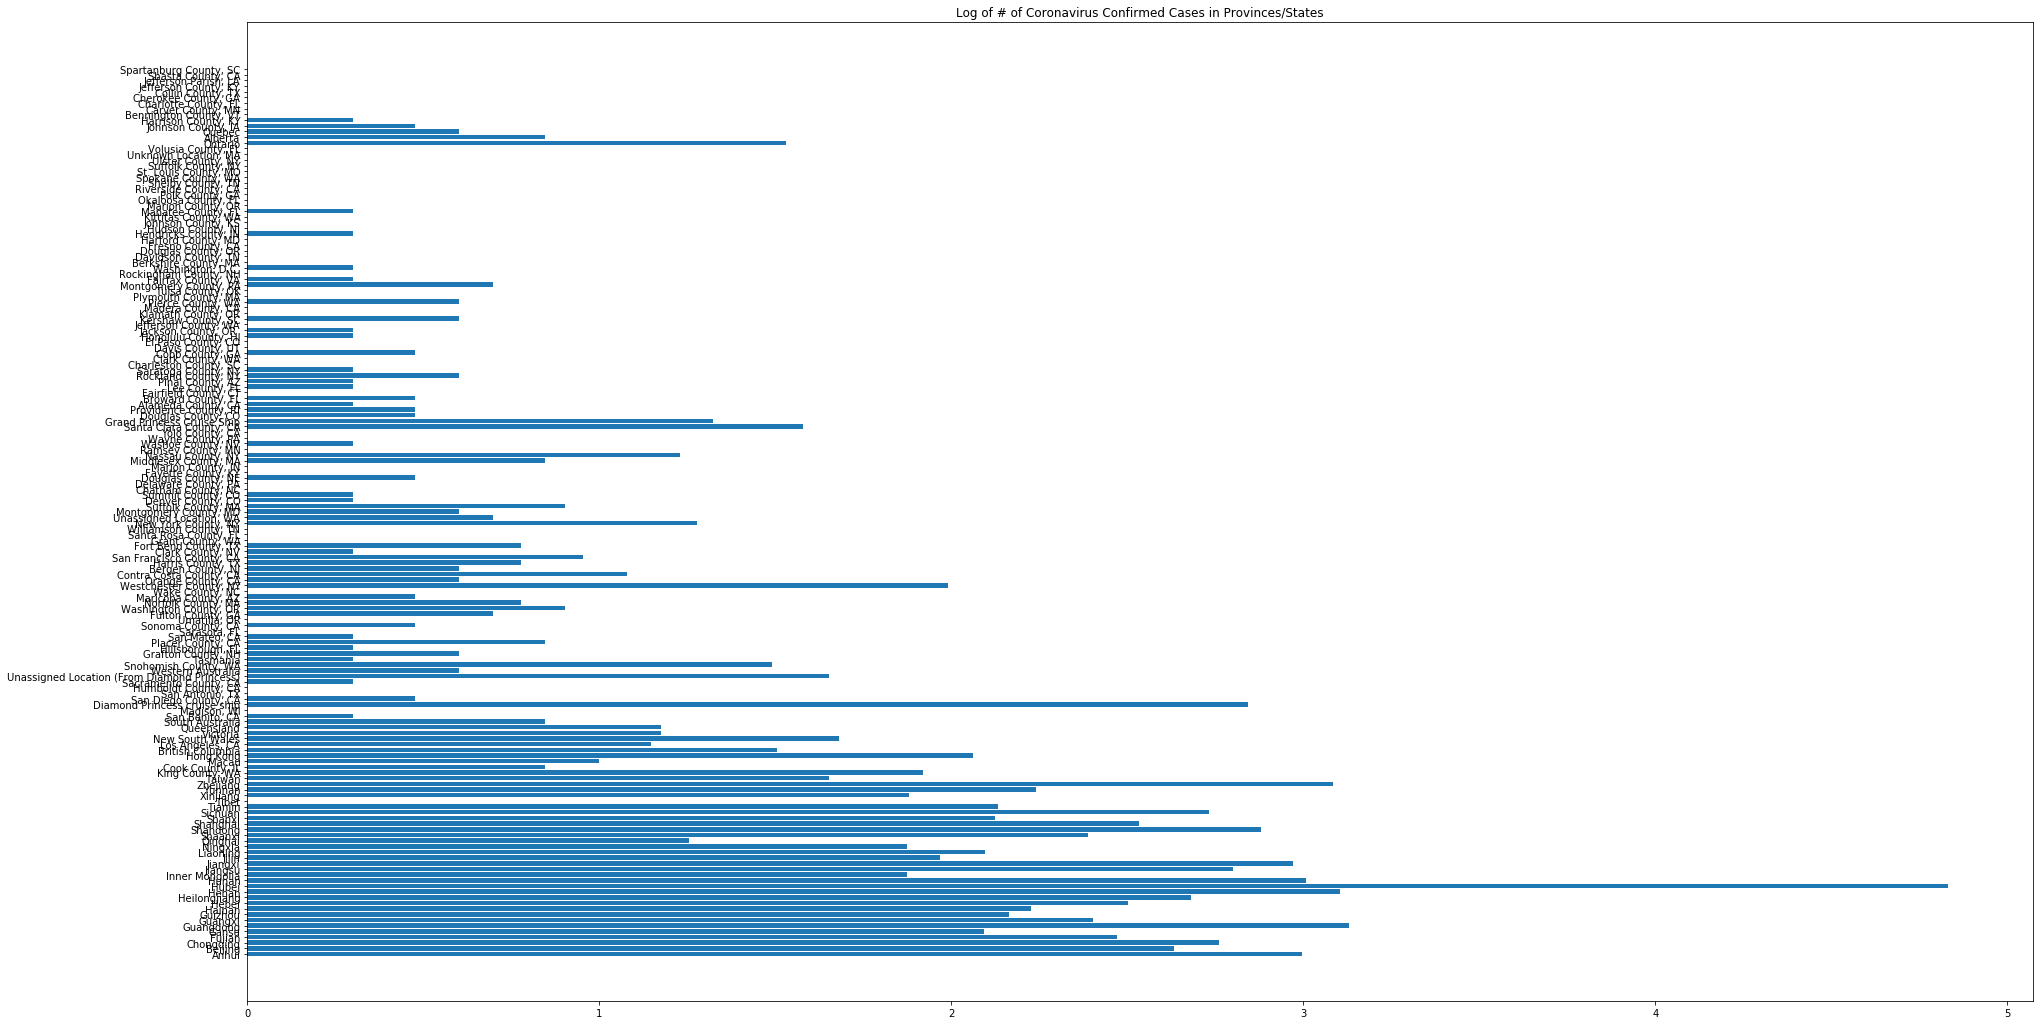

In [46]:
log_province_confirmed_cases = [math.log10(i) for i in province_confirmed_cases]
plt.figure(figsize=(32, 18))
plt.barh(unique_provinces, log_province_confirmed_cases)
plt.title('Log of # of Coronavirus Confirmed Cases in Provinces/States')
plt.show()

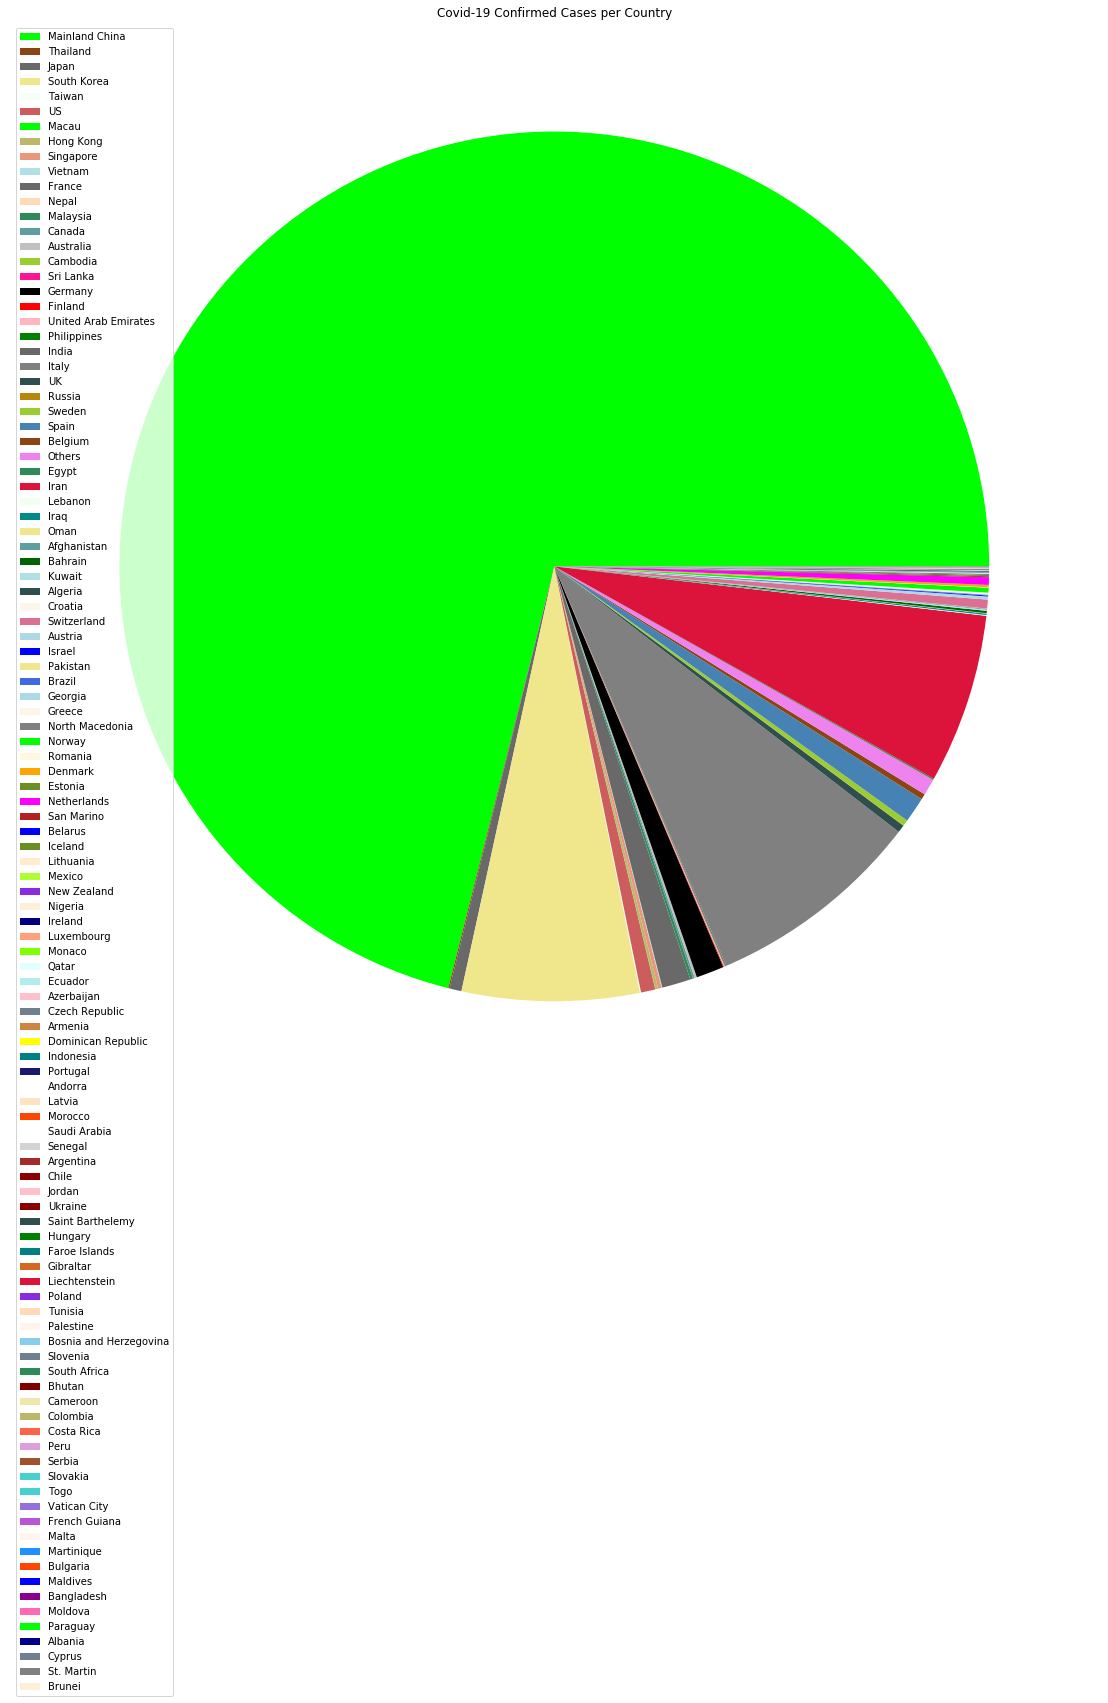

In [47]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases per Country')
plt.pie(country_confirmed_cases, colors=c)
plt.legend(unique_countries, loc='best')
plt.show()

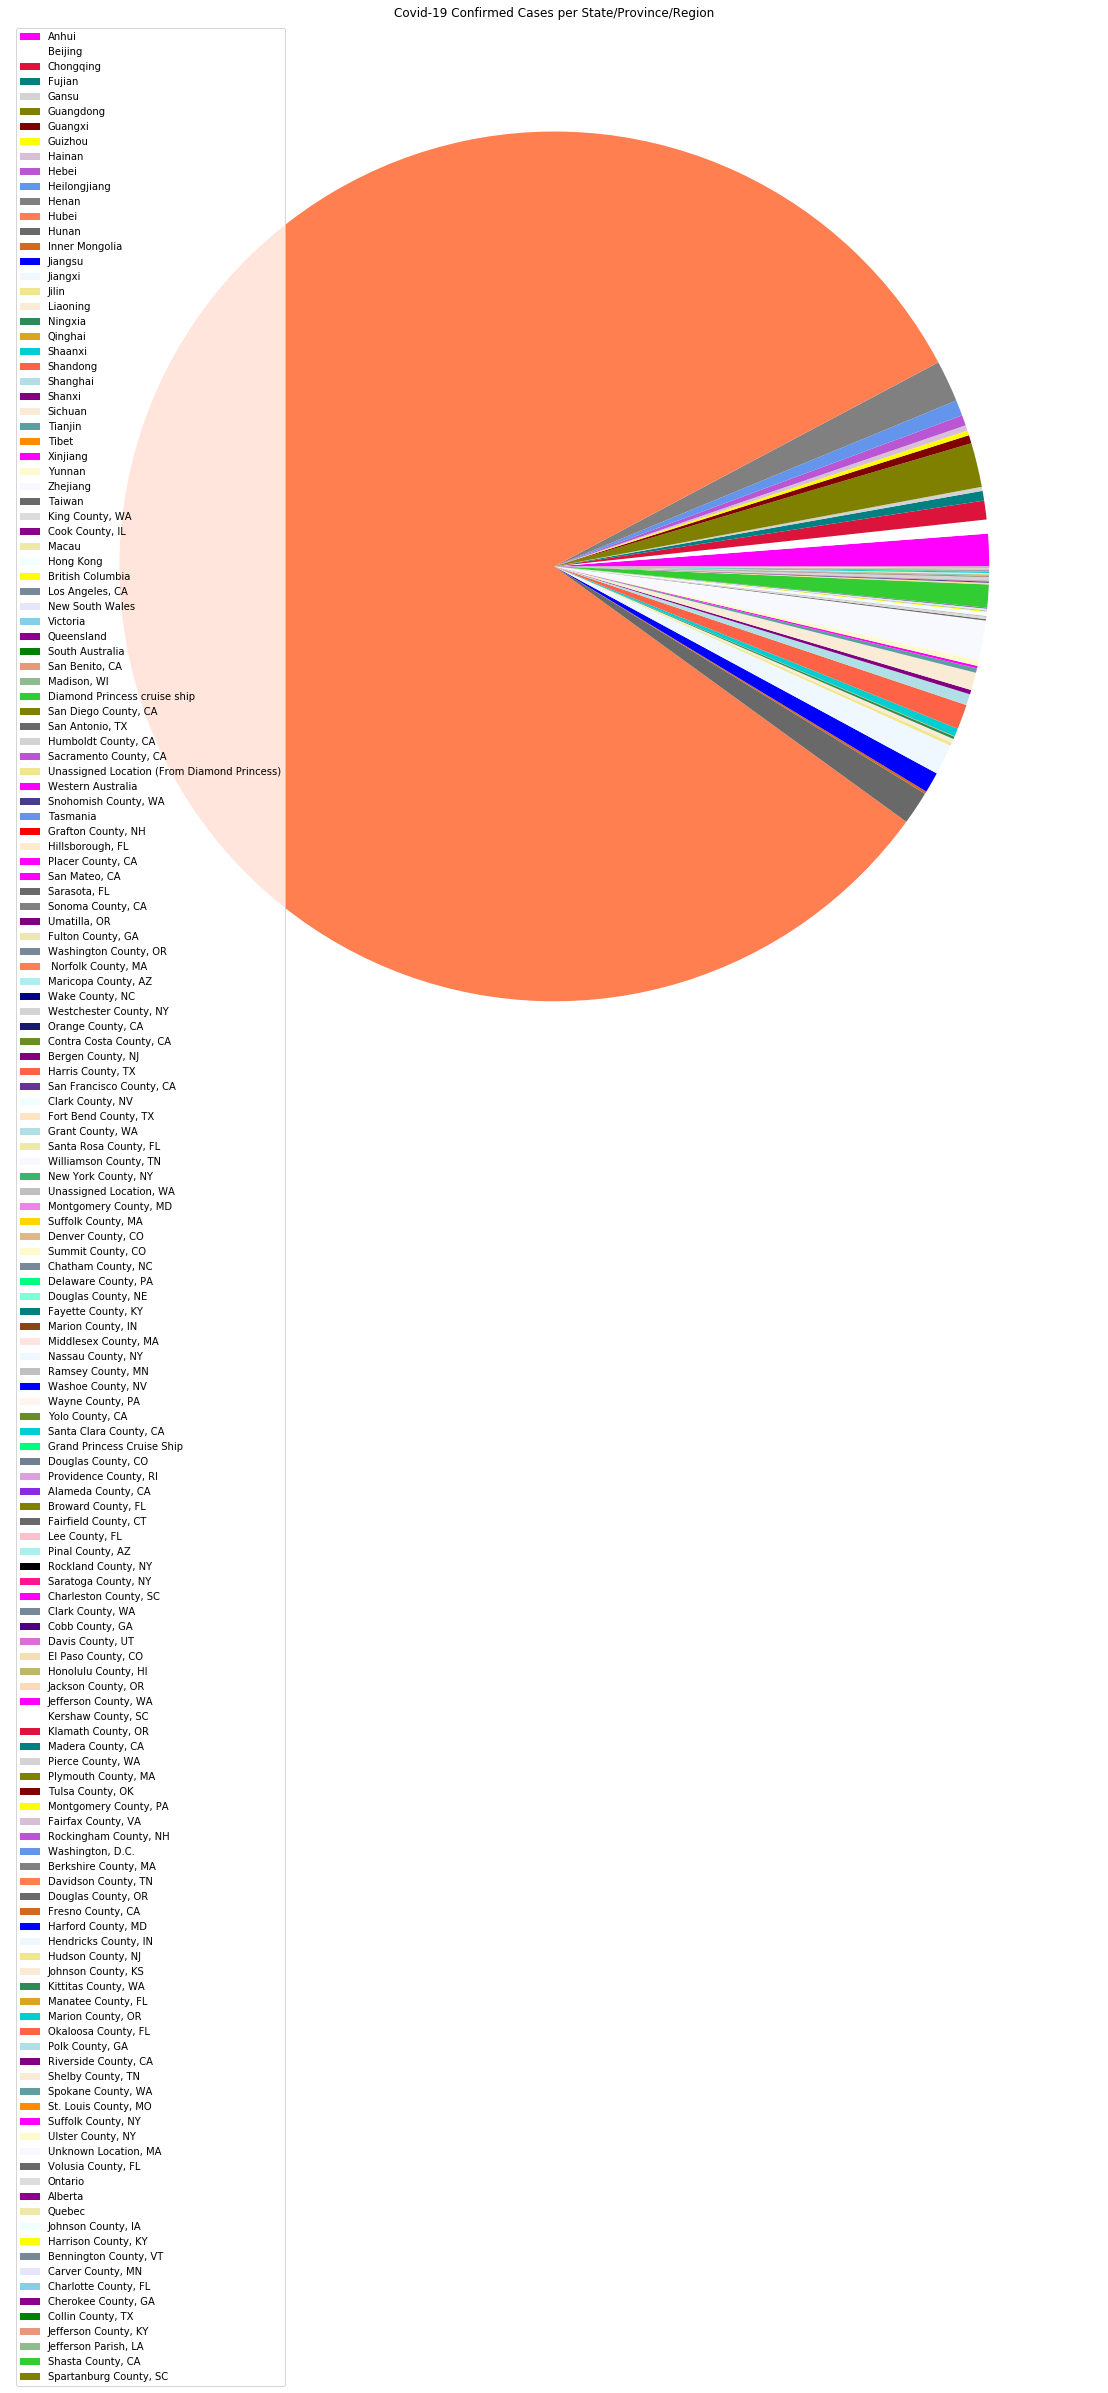

In [48]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases per State/Province/Region')
plt.pie(province_confirmed_cases, colors=c)
plt.legend(unique_provinces, loc='best')
plt.show()

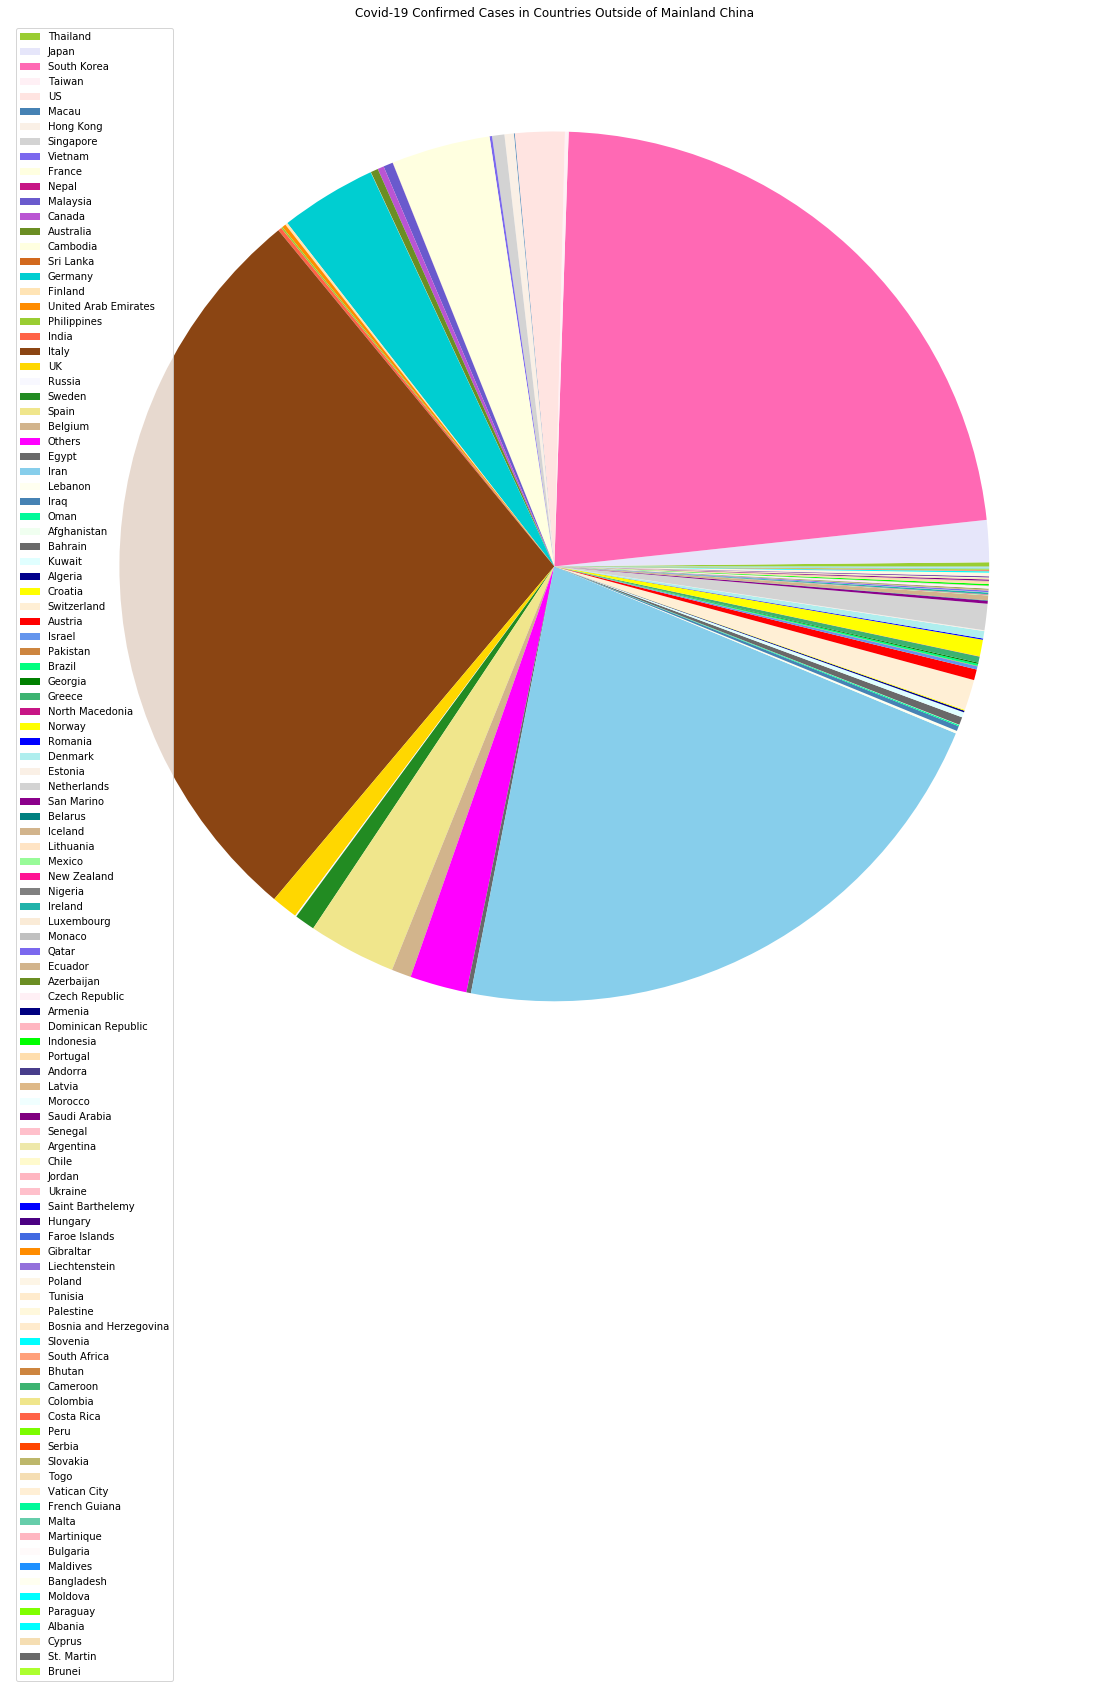

In [49]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases in Countries Outside of Mainland China')
plt.pie(country_confirmed_cases[1:], colors=c)
plt.legend(unique_countries[1:], loc='best')
plt.show()

In [50]:
us_regions = list(confirmed_df[confirmed_df['Country/Region']=='US']['Province/State'].unique())
us_confirmed_cases = []
no_cases = [] 
for i in us_regions:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        us_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    us_regions.remove(i)

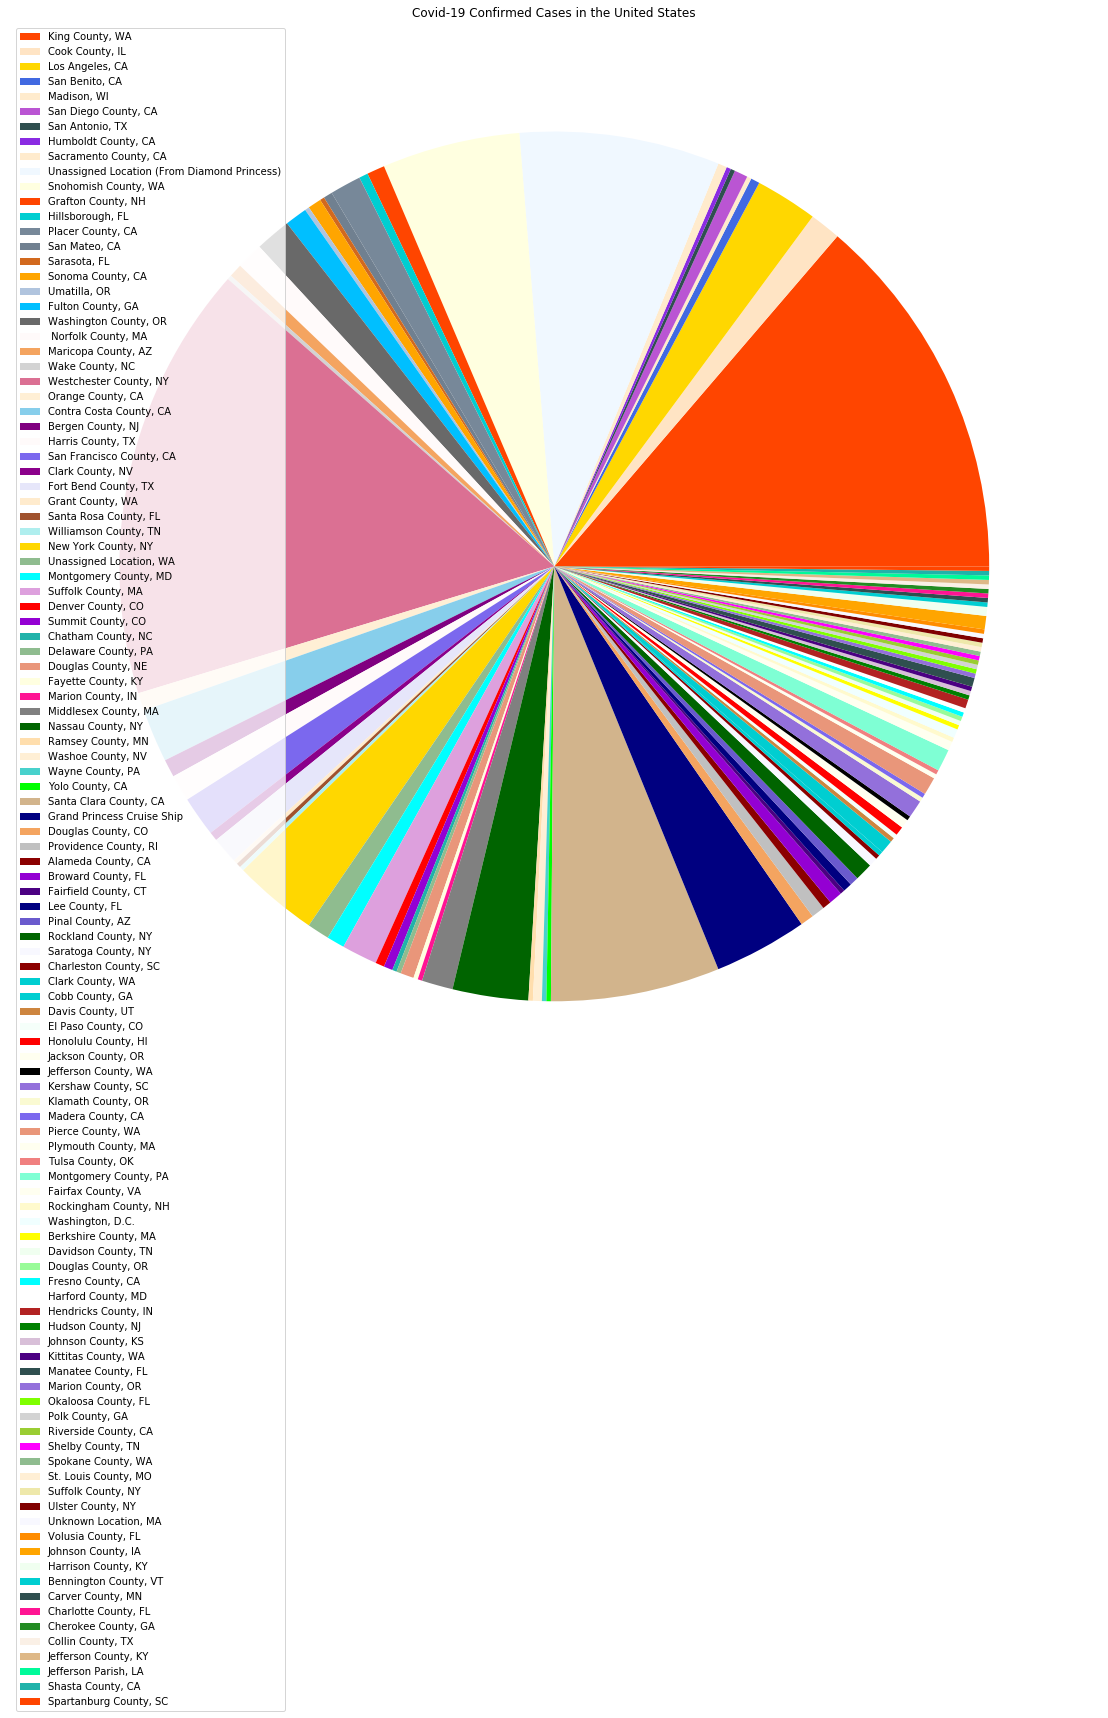

In [51]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases in the United States')
plt.pie(us_confirmed_cases, colors=c)
plt.legend(us_regions, loc='best')
plt.show()

In [52]:
china_regions = list(confirmed_df[confirmed_df['Country/Region']=='Mainland China']['Province/State'].unique())
china_confirmed_cases = []
no_cases = [] 
for i in china_regions:
    cases = latest_confirmed[confirmed_df['Province/State']==i].sum()
    if cases > 0:
        china_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    china_confirmed_cases.remove(i)

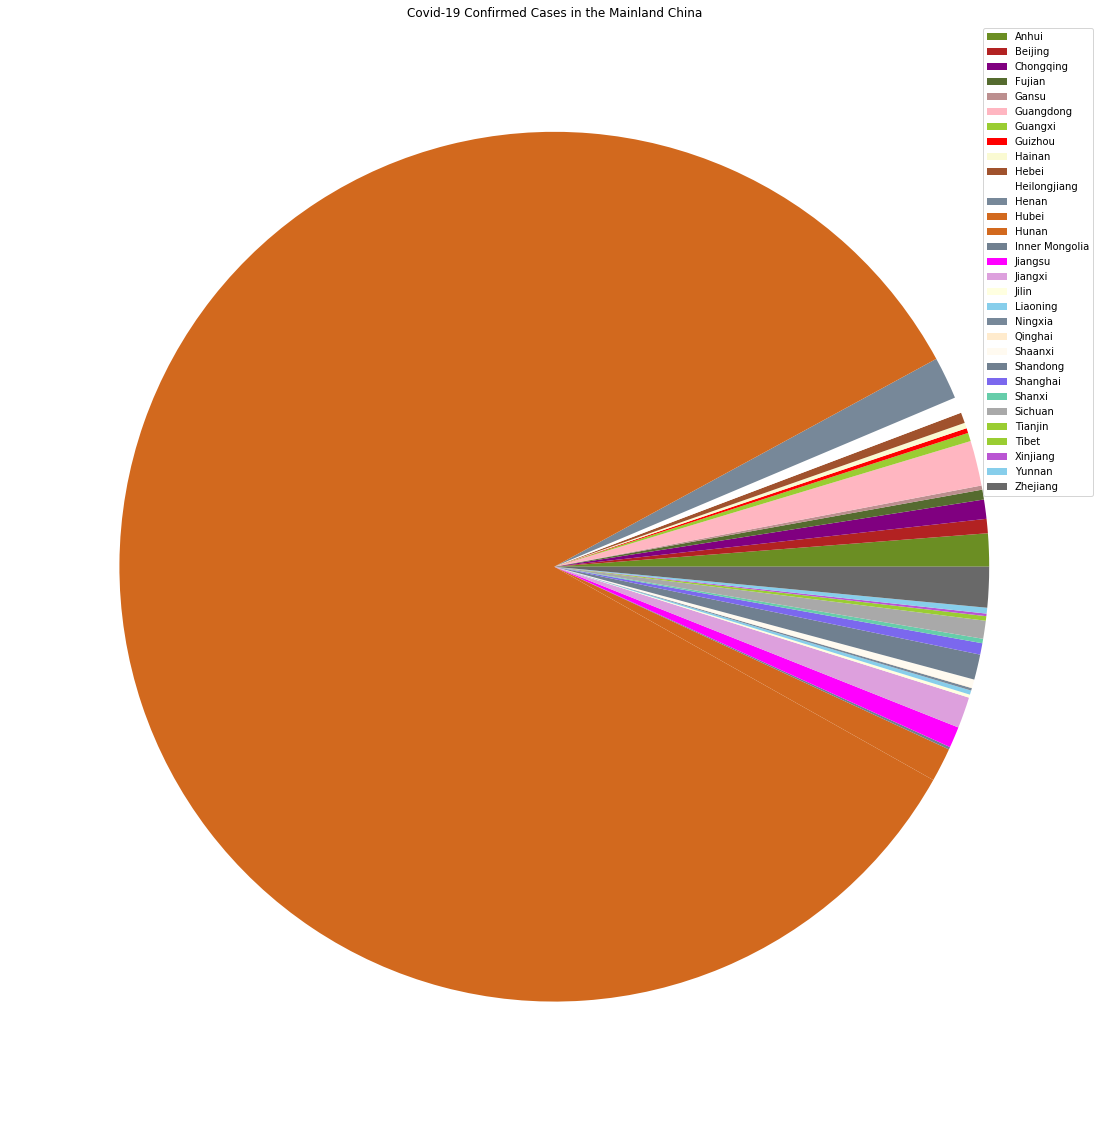

In [53]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,20))
plt.title('Covid-19 Confirmed Cases in the Mainland China')
plt.pie(china_confirmed_cases, colors=c)
plt.legend(china_regions, loc='best')
plt.show()